In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL
from libs.second_appr_simp_t import CorticalColumn, LayerConnection, AbstractRewardSystem, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection

In [2]:
seed = 1300
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

In [3]:
input_size = 200
each_session = 30
session_number = 1000
gap_time = 20

time = session_number * each_session
spike_train = torch.zeros(time, input_size).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2
pattern_size = int(input_size/2)

for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [4]:
spike_train.T[:, 100:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

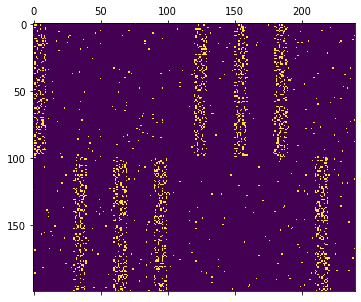

In [5]:
import matplotlib.pyplot as plt

plt.matshow(spike_train.T[:, :8 * each_session])

In [6]:
# connection_args_exc = { # Inside Layer
#     'wmin': 0.,
#     'wmax': 0.2,
#     'nu': 0.01,
#     'update_rule': PostPre,
# }
connection_args_inh = { # Inside Layer
    'wmin': -0.4,
    'wmax': 0,
#     'nu': 0.01,
    'update_rule': NoOp,
    'probability': 0.30,
#     'update_rule': PostPreInh,
}
exc_rec_con_args = { # Exc -> Exc
    'wmin': 0.,
    'wmax': 0.1,
    'nu': 0.01,
    'update_rule': NoOp,
}
connection_args = { # Between Layer
    'wmin': 0.,
    'wmax': 1.5,
    'nu': 0.01,
    'probability': 0.30,
    'weight_decay': 0.00002,
    'update_rule': MSTDPET_SEASONAL,
}
layer_args_l23 = {
    'exc_size': 100,
    'inh_con_args': connection_args_inh,
    'exc_rec_con_args': exc_rec_con_args,
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 20,
        'refrac': 5,
    }
}
layer_args_l4 = {
    'exc_size': 100,
    'inh_con_args': connection_args_inh,
    'exc_rec_con_args': exc_rec_con_args,
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 10,
    }
}
connection_type = RandomConnection

In [7]:
input_pop_c1 = Input(input_size, traces=True, tc_trace=10)
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, connection_type, name="c1", monitor=LAYER_23|LAYER_4)
input_to_c1_connection = LayerConnection(("input_c1", input_pop_c1), c1, connection_type, {
    'wmin': 0.,
    'wmax': 0.8,
    'nu': 0.01,
#     'update_rule': MSTDPET_SEASONAL,
    'update_rule': PostPre,
    'probability': 0.30
})

In [8]:
# class C1Reward(AbstractRewardSystem):
#     def __init__(self):
#         super().__init__()
#         self.set_cortical_column_and_classes(c1, timestep_class)

In [9]:
network = Network(dt=1.0) #, reward_update=True, reward_fn=C1Reward)
network.add_layer(input_pop_c1, "input_c1")
inp_monitor = Monitor(obj=input_pop_c1, state_vars=['s'])

inp_2_c1_monitor_1 = Monitor(obj=input_to_c1_connection.connections[0][2], state_vars=['converge'])
inp_2_c1_monitor_2 = Monitor(obj=input_to_c1_connection.connections[1][2], state_vars=['converge'])
network.add_monitor(monitor=inp_2_c1_monitor_1, name="inp_2_c1_monitor_1")
network.add_monitor(monitor=inp_2_c1_monitor_2, name="inp_2_c1_monitor_2")

bl_monitors = []
for a, b, con in c1.l4_l23.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    
network.add_monitor(monitor=inp_monitor, name="input_c1")
c1.add_to_network(network)
input_to_c1_connection.add_to_network(network)

In [10]:
from tqdm import trange

rewards = []
changes = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):
    
    inp = {'input_c1': spike_train[part*each_session:part*each_session+each_session, :]}
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c1.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c1.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c1.l23.monitors[0][1].get('s')[-each_session:,0,:].sum() - exc1_avg
    exc2_act = c1.l23.monitors[1][1].get('s')[-each_session:,0,:].sum() - exc2_avg
    
#     print(exc1_act, exc2_act)
    pattern = session_class[part]
    gap_check = abs(exc2_act - exc1_act) > 30
    
    exc1_wins = exc1_act > exc2_act
    reward = 1.2 if (exc1_wins == pattern) and gap_check else -1
    rewards.append(reward)
    
    #TODO Get trigger of connection
    for conn in c1.l4_l23.connections:
#     for conn in c1.l4_l23.connections + input_to_c1_connection.connections:
        change = conn[2].update_rule.trigger(reward)
        changes.append(change)
        
#     c1.pops_reset_state_variables()

100%|███████████| 1000/1000 [02:06<00:00,  7.88parts/s]


In [11]:
rewards

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1

In [12]:
# for i in range(100):
#     x = torch.linspace(-0.05, 0.05, steps=40)
#     plt.bar(x, torch.histc(changes[i], bins=40, min=-0.05, max=0.05), align='center', width=0.002)
#     plt.figure()

## Convergence

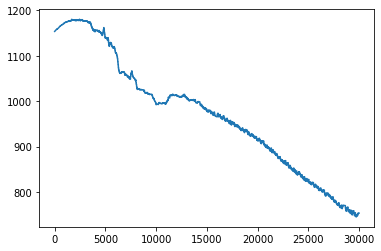

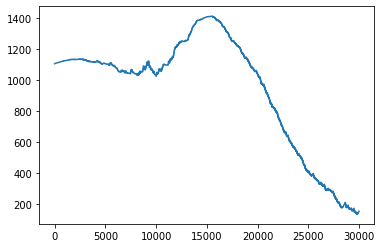

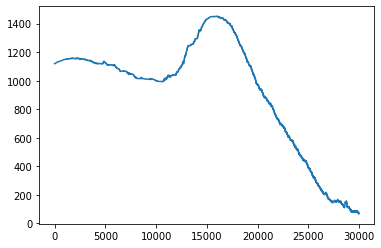

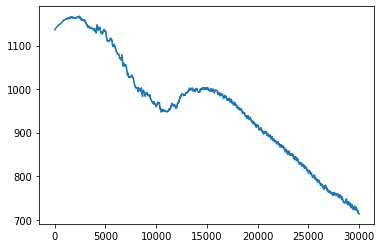

In [13]:
for m in bl_monitors:
    plt.figure()
    plt.plot(m.get('converge'))

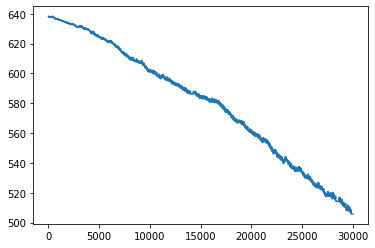

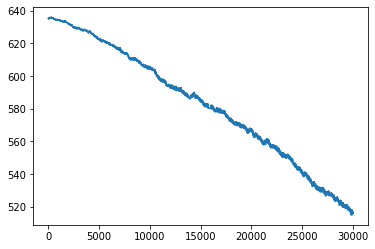

In [14]:
plt.plot(inp_2_c1_monitor_1.get('converge'))
plt.figure()
plt.plot(inp_2_c1_monitor_2.get('converge'))

In [15]:
time_show = time

In [16]:
spikes = {
    "L4 | 1": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c1.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Confusion

### Layer 4

In [17]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    0.0
L4 -- Excitatory 1 -- Pattern 2     :    100.0
L4 -- Excitatory 2 -- Pattern 1     :    99.98113250732422
L4 -- Excitatory 2 -- Pattern 2     :    0.0


In [18]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    8.395752906799316
L4 -- Excitatory 1 -- Pattern 2     :    90.72821807861328
L4 -- Excitatory 2 -- Pattern 1     :    93.54247283935547
L4 -- Excitatory 2 -- Pattern 2     :    11.69502067565918


### Layer 2,3

In [19]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    100.0
L23 -- Excitatory 1 -- Pattern 2     :    4.0
L23 -- Excitatory 2 -- Pattern 1     :    7.0
L23 -- Excitatory 2 -- Pattern 2     :    100.0


In [20]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    75.83783721923828
L23 -- Excitatory 1 -- Pattern 2     :    18.487552642822266
L23 -- Excitatory 2 -- Pattern 1     :    19.696910858154297
L23 -- Excitatory 2 -- Pattern 2     :    82.1058120727539


## Pattern Separation

In [21]:
for source, target, connection in input_to_c1_connection.connections:
    print(f"{source} (0:99)    --->   {target}   :   {connection.w[:100, :].sum()}")
    print(f"{source} (100:199) --->   {target}   :   {connection.w[100:, :].sum()}")

input_c1 (0:99)    --->   c1_l4__exc1   :   457.156494140625
input_c1 (100:199) --->   c1_l4__exc1   :   1096.46826171875
input_c1 (0:99)    --->   c1_l4__exc2   :   1094.0047607421875
input_c1 (100:199) --->   c1_l4__exc2   :   506.3795166015625


In [22]:

for source, target, connection in c1.l4_l23.connections:
    print(f"{source}   --->   {target}   :   {connection.w.sum()}")

c1_l4__exc1   --->   c1_l23__exc1   :   855.8109130859375
c1_l4__exc1   --->   c1_l23__exc2   :   4336.04052734375
c1_l4__exc2   --->   c1_l23__exc1   :   4508.86572265625
c1_l4__exc2   --->   c1_l23__exc2   :   980.4337768554688


## Activities

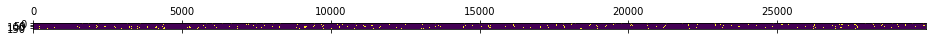

In [23]:
plt.matshow(spike_train.T[:, -time_show:])

In [24]:
c1.l4.monitors[0][1].get('s').shape

torch.Size([30000, 1, 100])

In [25]:
spikes["L4 | 1"].shape

torch.Size([100, 30000])

In [26]:
spikes["L4 | 1"].sum(0).shape[0]

30000

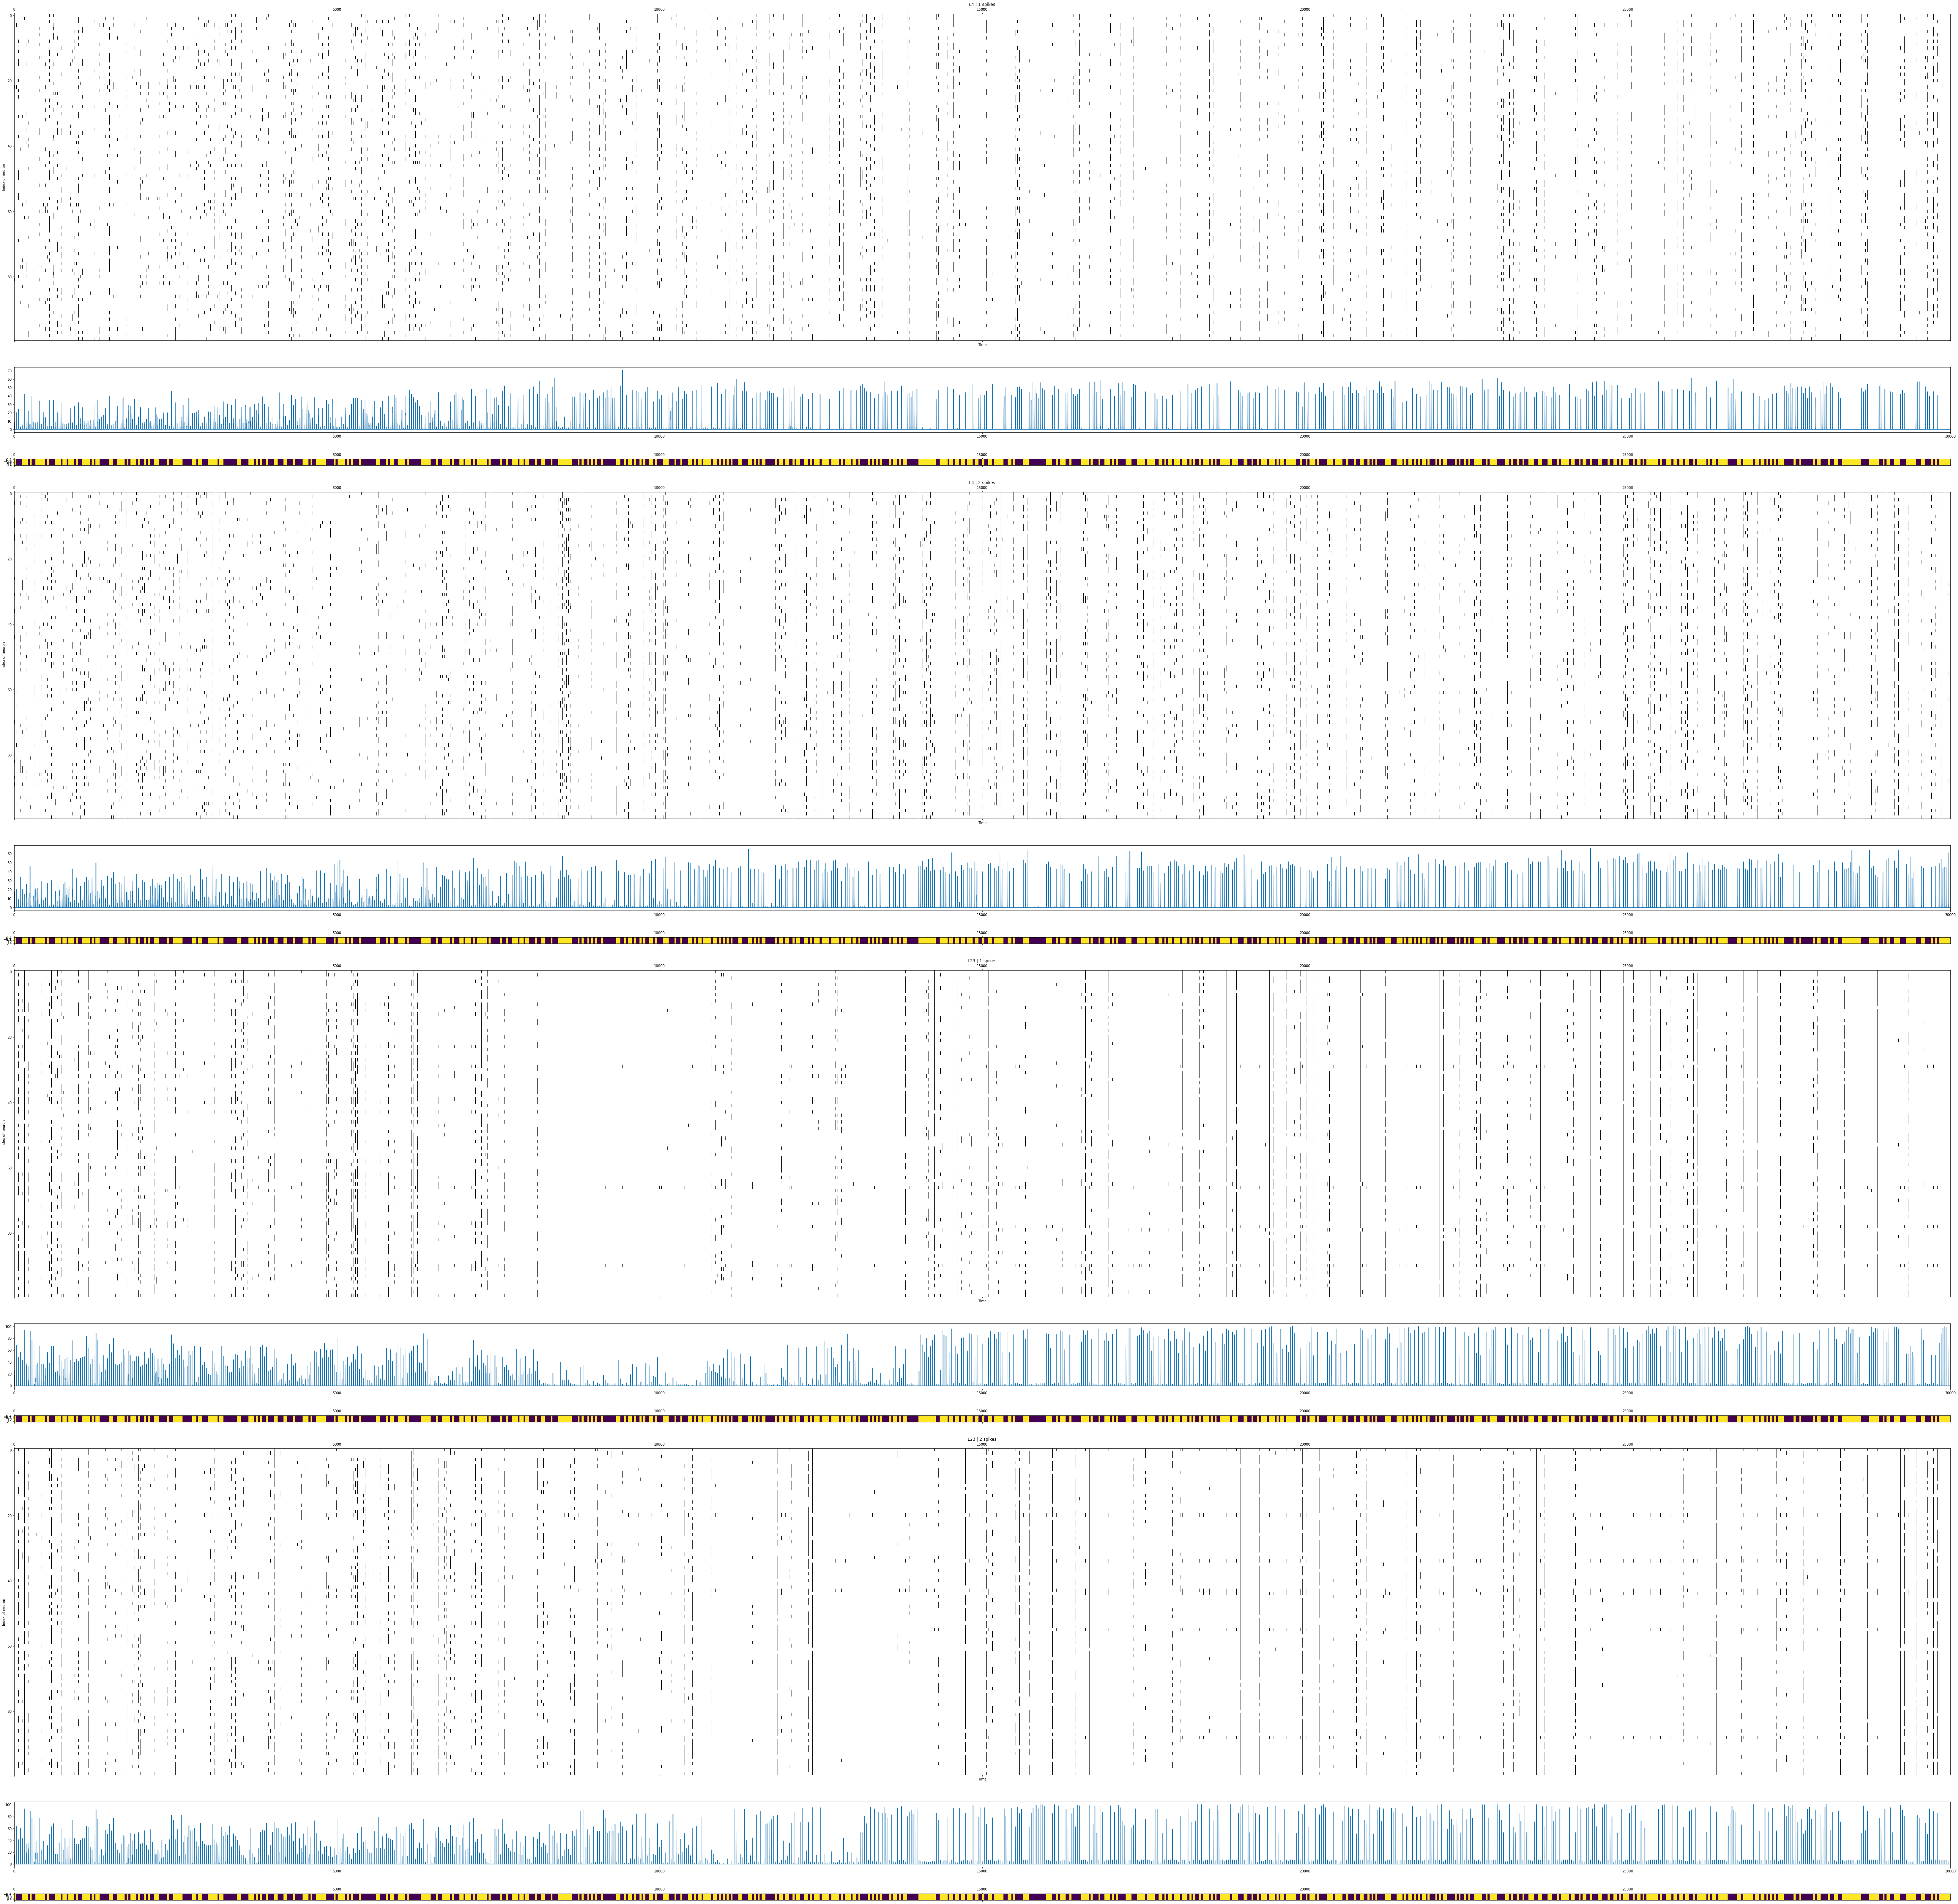

In [27]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')